In [16]:
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from ProfileUtils import galaxy_cutout, sky_background, mask_sources, plateau_finder
from radial_profile import RadialProfile

In [61]:
# load our sample galaxy image at 250 microns
image = fits.open('/Users/prometheus/radial-profile-utils/sample_data/NGC4535_SPIRE_250_bkgsub.fits')[0]
error = fits.open('/Users/prometheus/radial-profile-utils/sample_data/NGC4535_SPIRE_250_Error.fits')[0]
# load VERTICO table to get positional data
path = '/Users/prometheus/radial-profile-utils/sample_data/vertico_table1.fits'
table = fits.open(path)[1].data
# find our galaxy
table = table[table['Galaxy'] == 'NGC4535'][0]

In [62]:
# get columns
name, ra, dec, inclination, pa = table['Galaxy'], table['RA'], table['DEC'], table['inclination'], table['pa']
# get pixelscale
ps = round(abs(image.header['CDELT1']*3600),2)

In [63]:
# create cutout
cutout, centre, r = galaxy_cutout.galaxy_cutout(image.data, image.header, ra, dec, name, size = 8.0, centre_and_radius = True)

# error cutout
error_cutout = galaxy_cutout.galaxy_cutout(error.data, error.header, ra, dec, name, size = 8.0)

number of masked objects is:  8
NGC4535
found you:  NGC4535


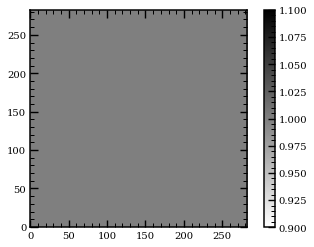

In [64]:
# mask our sources prior to cutout. Stored in MaskSources.disk_mask attribute. Takes a couple seconds to run.
mask = mask_sources.MaskSources(cutout.data, image.header, name, path, ps = ps).disk_mask

cutout.data *= mask

plt.imshow(mask, origin = 'lower', cmap = 'binary')
plt.colorbar()
plt.show()

In [56]:
# create cutout
cutout, centre, r = galaxy_cutout.galaxy_cutout(image.data, image.header, ra, dec, name, size = 8.0, centre_and_radius = True)

# error cutout
error_cutout = galaxy_cutout.galaxy_cutout(error.data, error.header, ra, dec, name, size = 8.0)

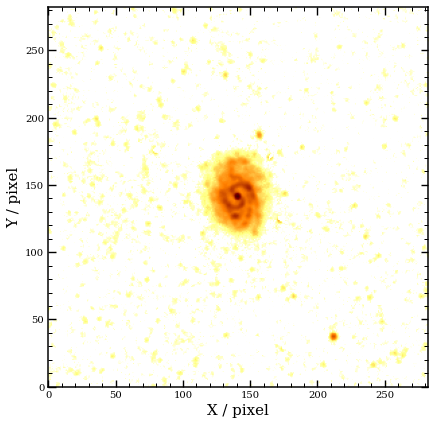

In [57]:
# simple log plot
norm = LogNorm(vmin = 5e-4, vmax = 0.5, clip = True)
fig, ax = plt.subplots(figsize = (8,7))
ax.imshow(cutout.data, origin = 'lower', norm = norm, cmap = 'afmhot_r')
#format ticks
startx, endx = ax.get_xlim()
starty, endy = ax.get_ylim()
ax.xaxis.set_ticks(np.arange(0, endx, 50))
ax.yaxis.set_ticks(np.arange(0, endy, 50))
ax.set_aspect('equal', 'box')
ax.set_xlabel('X / pixel', fontsize = 15)
ax.set_ylabel('Y / pixel', fontsize = 15)
plt.show()

In [58]:
# can first create radial profile and then calculate sky background
profile = RadialProfile(cutout.data, centre, inclination, pa, error_cutout.data)

# make N annuli such that we reach 3.5R25 along semi-major axis
resolution = 18 #arcseconds
min_width_minor = resolution/ps/2 # min width will be half the resolution along minor axis
min_width_major = min_width_minor / np.cos(np.deg2rad(inclination)) # min_width in major axis to use
n_annuli = round(3.5 * r / 6 / min_width_major) # round to N annuli
rp = profile.calc_radial_profile(
    n_annuli=n_annuli,    # number of annuli to fit
    header=image.header,
    wcs=cutout.wcs,
    include_bad=False,    # do not include NaNs/infs in any calculations
                          # If True, include NaNs/infs as zeros in calculations
    func="mean",          # "mean" or "median"
    is_radio=False,
    min_width_ax="major",  # sets which axis we consider our minimum annuli size
    min_width=min_width_major,
    radius_type="mid",    # use the annuli's midpoints along the major axis as the radii
)


Info: using provided WCS instead of converting header to WCS


In [49]:
# compute sky background
sky_bkg = sky_background.sky_background(cutout.data, centre, )

2.2597226287176513